# **OSMnx**

> OSMnx es un paquete de Python que permite descargar datos espaciales de OpenStreetMap y modelar, proyectar, visualizar y analizar redes de calles del mundo real. Puedes descargar y modelar redes urbanas peatonales, conducibles o ciclovía con una sola línea de código Python y luego analizarlas y visualizarlas fácilmente. También puede descargar y trabajar con otros tipos de infraestructura, servicios/puntos de interés, huellas de edificios, datos de elevación, orientación de las calles y velocidad/tiempo de viaje.

OpenStreetMap es un proyecto para crear mapas abiertos, mantenido por colaboradores alrededor del mundo. Por lo tanto usando la información disponible en OpenStreetMap y la librería OSMnx, se pueden realizar análisis urbanos usando Python sin tener el problema de accesibilidad y consistencia de información espacial, con la posibilidad de exportar los resultados para su uso posterior en un SIG. Usando esta librería se puede obtener, por ejemplo un analisís de centralidad de cualquier ciudad del mundo en minutos, sin la necesidad de recolectar y preprocesar datos que otros metodos tradicionales de análisis urbano exigen.

**El proceso de análisis descrito a continuación asume que la información disponible en [OpenStreetMap](https://www.openstreetmap.org/#map=14/4.8573/-74.0709https://www.openstreetmap.org/#map=14/4.8573/-74.0709) es una representación adecuada de areá de interés, si existen zonas sin mapear o incorrrectamente mapeadas, considere agregar o editar la información [aquí](https://www.openstreetmap.org/user/new).**

A continuación se presenta el procedimiento para realizar una analisis espacial del municipio de **Chía** usando **OSMnx**. La librería ofrece muchas otras posibilidades para el análisis urbano, para mayor información consultar: [**documentación oficial**](https://osmnx.readthedocs.io/en/stable/),  [**página web del autor**](https://geoffboeing.com/) y [**ejemplos**](https://github.com/gboeing/osmnx-examples) adicionales. De no encontrar alguna función de la documentación oficial consultar la documentación de: [**NetworkX**](https://networkx.org/documentation/stable/), [**matplotlib**](https://matplotlib.org/stable/contents.html), [**GeoPandas**](https://geopandas.org/docs/reference.html) librerías de las que **OSMnx** importa funciones.

## **1. Importar librerías necesarias**
Todas las librerías importadas vienen incluidas en la instalación de OSMnx, sí se presentan errores reinstalar la librería utilizando los [comandos](https://osmnx.readthedocs.io/en/stable/index.html#installationhttps://osmnx.readthedocs.io/en/stable/index.html#installation).

In [216]:
import networkx as nx # Analisis de grafos
import osmnx as ox
import pyproj # Proyecciones
import pandas as pd # Manipulación tablas
import geopandas as gpd # Extensión de pandas con soporte para operaciones espaciales
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

ox.config(log_console=True)
ox.__version__

'1.0.1'

## **2. Descargar, preprocesar y exportar información del areá de interés**
### **2.1**. Descargar grafo de un municipio
Para descargar un municipio se pasa su nombre como una cadena de caracteres: `"Chía, Colombia"`, también es posible descargar información de varios lugares a la vez, pasando una lista, por ejemplo:`ciudad = ["Chía, Colombia", "Cajíca, Colombia"]`. Si no se obtienen resultados consultar [OpenStreetMap](https://www.openstreetmap.org/) para confirmar que el lugar se encuentre mapeado.

Entre las opciones para el argumento `network_type` se encuentran: 
- `"drive"`: calles públicas donde es posible conducir.
- `"bike"`: ciclovía
- `"walk"`: Todas las calles y senderos a las que los peatones pueden acceder
- `"all"`: Toda la informacipon disponible, con excepción de vías de acceso privado

Para visualizar el grafo se usa la función `ox.plot_graph()`, la cual genera un gráfico al cual se le pueden agregar especificaciones adicionales usando la sintaxis de [matplolib](https://matplotlib.org/stable/contents.html). En este caso se elige no visualizar los nodos`node_size=0`.

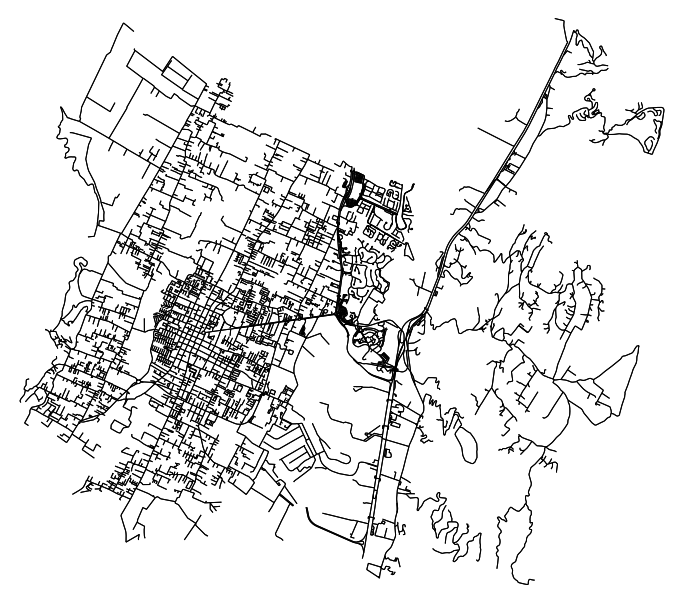

In [136]:
ciudad = "Chía, Colombia" # Nombre ciudad a descargar
network_type = "walk"
G_place = ox.graph_from_place(ciudad, network_type=network_type)
# Visualizar grafo descargado
fig, axes = ox.plot_graph(G_place, figsize=(12,12), edge_color='black', edge_linewidth=1, bgcolor='white', node_size=0)

### **2.2.** Descargar grafo delimitado por un rectangulo
OSMnx permite descargar las calles que se encuentren dentro de un rectangulo, específicadas en coordenadas geográficas. Cualquiera de los dos grafos descargados: `G_place` o `G_bbox` se puede usar para continuar con el análisis. 

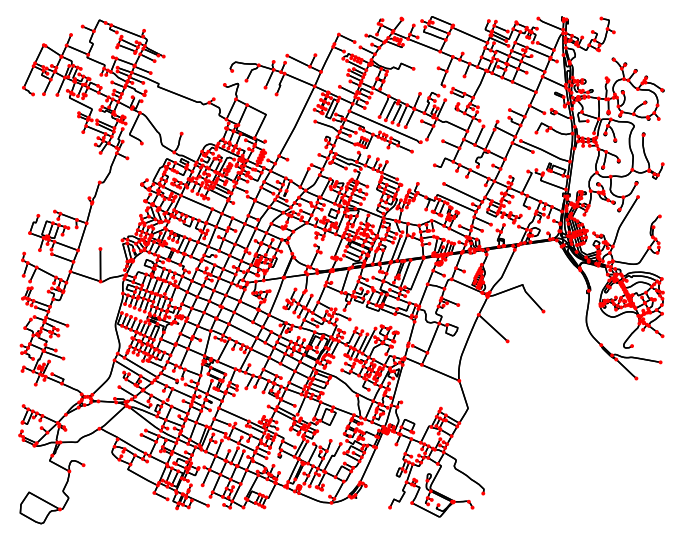

In [137]:
norte, sur, este, oeste = 4.8791797, 4.8477755, -74.0729054, -74.0316090
network_type = "walk"
G_bbox = ox.graph_from_bbox(norte, sur, este, oeste, network_type=network_type)
# Visualizar grafo descargado
fig, axes = ox.plot_graph(G_bbox, figsize=(12,12), edge_color='black', edge_linewidth=1.5, bgcolor='white', node_color='r')

### **2.3.** Consolidar, proyectar el grafo y exportar el grafo
El grafo descargado anteriormente, tiene ciertas imprecisiones al representar la ciudad, por ejemplo, diferentes carriles de una misma autopista podrían tener asignado un vertice cada uno. Para solucionar este problema se debe consolidar las entidades e intersecciones que se encuentren dentro de una distancia específica: `tolerance`. 
Antes de consolidar, se proyecta el grafo a un sistema de coordenadas planas, en este caso [EPSG:3116](https://spatialreference.org/ref/epsg/3116/) (MAGNA-Colombia-Bogotá), con el fin de especificar el valor de `tolerance` en metros. El código EPSG de las proyecciones se puede consultar en [spatialreference.org](https://spatialreference.org).

Para la funcion `ox.consolidate_intersections` el valor del argumento`tolerance` debe ajustarse hasta representar aproximadamente la red vial, el argumento `dead_ends` determina si se descargan calles con una única conexión, calles cerradas.

Finalmente se exporta el archivo en formato *shapefile* para su uso en SIG, el argumento `file path` indica la carpeta donde se guardará el grafo. También se puede exportar a formato *GeoPackage* usando  la función `ox.save_graph_geopackage()`.

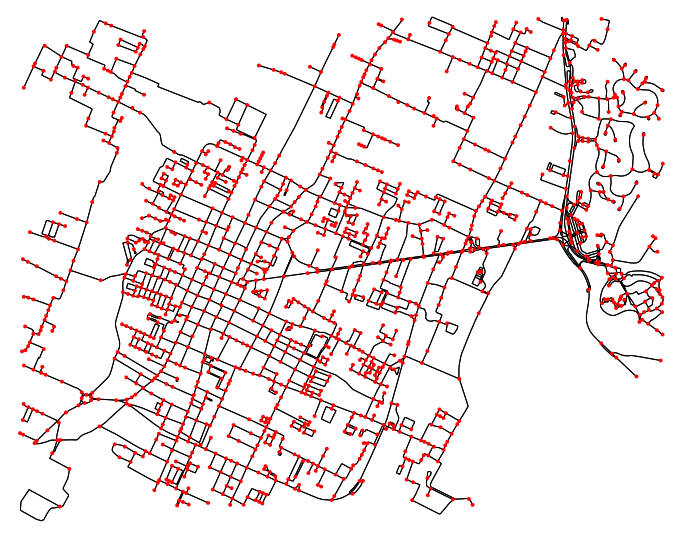

In [225]:
G = G_bbox # Asignar a G uno de los grafos descargados anteriormente "G_place"o "G_bbox"
epsg_code = 3116
G_proj = ox.project_graph(G, pyproj.CRS.from_user_input(epsg_code))
G2 = ox.consolidate_intersections(G_proj, tolerance=10, dead_ends=False)
fig, axes = ox.plot_graph(G2, figsize=(12,12), edge_color='black', edge_linewidth=1, bgcolor='white', node_color='r')
# Guardar grafo a shapefile
ox.save_graph_shapefile(G2, filepath='./data/graph_chiá_tol10')

## **3. Realizar analisís estadístico y de centralidad**
### **3.1.** Calcular estadísticas de cada nodo
OSMnx permite calcular métricas locales y globales d eun grafo. La función `ox.basic_stats()` calcula métricas globales que no requieren de calculos complejos para cada nodo. Por otra parte, la función `ox.extended_stats()` ejecuta algoritmos que requieren crear una matrix completa ***nxn*** para ***n*** nodos,  por lo que puede tardar un tiempo considerable de ejecución. Por esta razón se recomienda calcular solo las métricas estritamente necesarias.

La función `ox.extended_stats()` permite calcular los siguientes conjuntos de estadísticas:
- `connectivity`: Conectividad de nodos y vértices 
- `anc`: Conectividad promedio de los nodos
- `ecc`: Rutas más cortas, excentricidad y métricas derivadas
- `bc`: *Betweenness*, equivalente a la medida **choice** en *Space Syntax*
- `cc`: *Closeness*, equivalente a la medida **integration** en *Space Syntax*

La lista de cada una de las estadísticas que calcula la función `ox.extended_stats()` se encuntentra [aquí](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=extended%20stats#osmnx.stats.extended_stats), para mayor información sobre cada estadística consultar la [documentación](https://networkx.org/documentation/stable/_downloads/networkx_reference.pdf) de NetworkX.

Esta sección puede tardar, especialmente si se procesan grafos extensos ya que su complejidad crece exponecialmente con el número de nodos.

In [139]:
#Calcular area de grafo para medidas de densidad
area = ox.project_gdf(ox.geocode_to_gdf(ciudad)).unary_union.area
stats = ox.basic_stats(G2, area=area)

# Calcular estadísticas, asignar argumento a "True" solo si es necesario
extended_stats = ox.extended_stats(G2, bc=True, cc=True) 
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                   1517
m                                                                                   4110
k_avg                                                                           5.418589
intersection_count                                                                  1218
streets_per_node_avg                                                            2.502966
streets_per_node_counts                              {0: 0, 1: 0, 2: 0, 3: 1075, 4: 143}
streets_per_node_proportion            {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.7086354647330257...
edge_length_total                                                          329557.832732
edge_length_avg                                                                80.184388
street_length_total                                                        165432.595523
street_length_avg                                                               80.26812
street_segments_count

### **3.2.** Visualizaciones de centralidad
Las metrícas de centralidad se calculan a partir de las rutas mas cortas usando la distancia a cada nodo.Para faciltiar la comparación de centralidad entre diferentes nodos se produce una visualización. La medida ***betweenness*** indica proporción en la que un nodo se encuntra en la ruta más costa entre dos nodos. Por su parte la medida de ***closeness*** indica que tan cerca se encuentra un nodo de todos los demas.

Antes de graficar se deben añadir la información de centralidad al grafo, ya que hasta el momento las estadísticas estan almacenadas en una variable diferente. La función `set_node_attributes` añade información a cada, la cual se conserva cuando se exporta el grafo, así que se puede realizar un análisis mas profundo de los resultados en otra herramienta como: GeoDa, ArcGIS, etc.

Visualización de centralidad (BETWEENNESS)
Por el nodo mas central pasan un 24.44% de las rutas mas cortas entre todos los nodos.


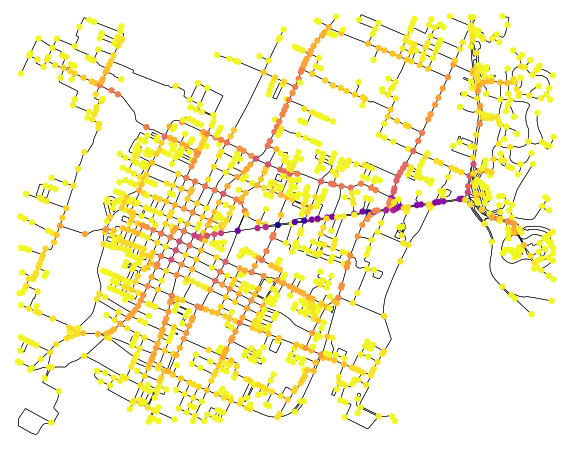

Visualización de centralidad (CLOSENESS)


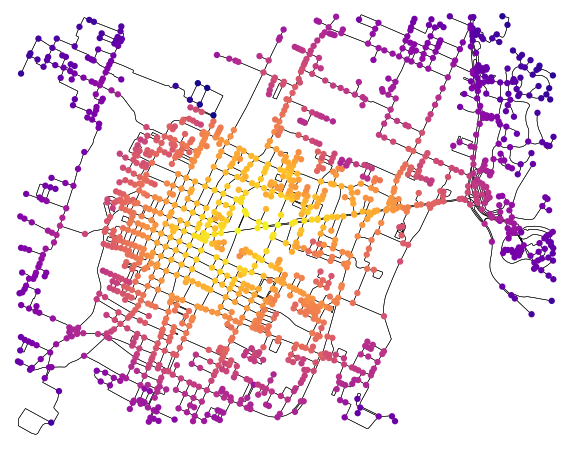

In [140]:
# Asignar atributos centralidad al grafo
nx.set_node_attributes(G2, extended_stats['betweenness_centrality'], 'bc')
nx.set_node_attributes(G2, extended_stats['closeness_centrality'], 'cc')

# Obtener esquemas de color de acuerdo a los atributos
ncbc = ox.plot.get_node_colors_by_attr(G2, 'bc', cmap='plasma_r')
nccc = ox.plot.get_node_colors_by_attr(G2, 'cc', cmap='plasma')

# Valor máximo de centralidad
maxbc = max(extended_stats['betweenness_centrality'].values())

print("\033[1mVisualización de centralidad (BETWEENNESS)\033[1m")
print("Por el nodo mas central pasan un %.2f%% de las rutas mas cortas entre todos los nodos." % (maxbc*100))
# Visualizar betweenness
fig, ax = ox.plot_graph(G2, figsize=(10,10), bgcolor='white', edge_color='k', edge_linewidth=0.5,                        
                        node_color=ncbc, node_size=40, node_zorder=2)

print("\033[1mVisualización de centralidad (CLOSENESS)\033[1m")
# Visualizar closeness
fig, ax = ox.plot_graph(G2, figsize=(10,10), bgcolor='white', edge_color='k', edge_linewidth=0.5,
                        node_color=nccc, node_size=40, node_zorder=2)

#Guardar grafo como shapefile (incluyendo información de centralidad)
ox.save_graph_shapefile(G2, filepath='./data/graph_chiá_centrality')

## **4. Visualizar Isocronos distancia de viaje**
OSMnx permite determinar los nodos que se pueden alcanzar en un intervalo de tiempo, partiendo de un nodo específico. Posteriormente se asigna a cada nodo un atributo que indica si un nodo cualquiera se puede alcanzar desde el nodo inicial en un tiempo limitado.

### **4.1.** Determinar los nodos que se pueden alcanzar para cada intervalo de tiempo
Introducir la ubicación del nodo inicial, en las mismas coordenadas en las que se encuentra el grafo, en este caso `G2` se encuentra proyectado. Si se trabaja en coordenadas geográficas asignar `method="haversine"`. Para este ejemplo se considera el parque principal de Chía como el punto inicial.

In [193]:
trip_times = [5, 10, 15, 20, 25, 30] # Tiempo recorrido (min)
vel = 5 # km/h. Velocidad promedio peatón
vel_mmin = vel*1000/60 # m/min
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', return_hex=True) # Colores para cada isocrono

# Punto desde el cual se calcularan el tiempo de recorrido
x, y = 1001918.9143, 1029311.6178 # Coordenadas proyectadas MAGNA-Colombia-Bogotá(EPGS:3116)
initial_node = ox.get_nearest_node(G2, (y,x), method="euclidean")

# Calcular tiempo requerido para recorrer cada vértice
for u, v, k, data in G2.edges(data=True, keys=True):
    data['time'] = data['length'] / vel_mmin

### **4.2.** Crear y graficar polígonos correspondientes a cada isocrono
La función `make_iso_polys` se encarga de crear los polígonos y recibe los argumentos `edge_buff` y `node_buff` que corresponden a la distancia adicional que se incluirá desde los vértices y nodos respectivamente. Las unidades de distancia deben ser las mismas que el grafo que procesa. Los isocronos pueden ser exportados a shapefile, y [otros formatos](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.to_file.html#geopandas-geoseries-to-file) soportados por GeoPandas.

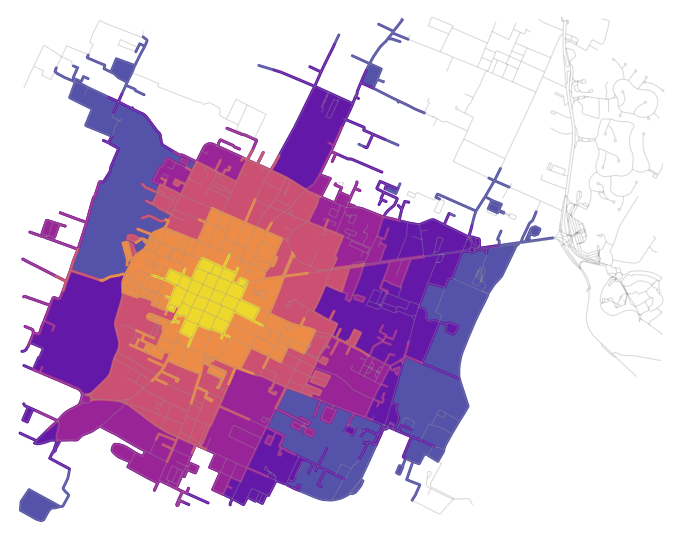

In [229]:
# Function crear polígonos
def make_iso_polys(G, edge_buff=15, node_buff=25, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, initial_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G2, edge_buff=10, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G2, figsize=(12,12), bgcolor='w', show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.7, zorder=-1)
    ax.add_patch(patch)

gpd.GeoSeries(isochrone_polys).set_crs(epsg=epgs_code).to_file("./data/isocronos_chía.shp")